In [40]:
!pip install colorama

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
import folium
from colorama import Fore, Style, init
from IPython.display import display
from geopy.distance import geodesic
from datetime import datetime

# Initialize colorama for nice console output
init()

# Print execution info
print(f"Execution Date and Time: 2025-03-25 05:36:33")
print(f"User: kripa-sindhu-007\n")

Execution Date and Time: 2025-03-25 05:36:33
User: kripa-sindhu-007



In [45]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # Mass of the vehicle (kg)
    "wheel_radius": 0.2848,  # Wheel radius (meters)
    "transmission_ratio": 5.763,  # Transmission ratio from motor to wheels
    "transmission_efficiency": 0.95,  # Transmission efficiency coefficient
    "drive_efficiency": 0.85,  # Powertrain efficiency coefficient
    "a0": 125.73,  # Rolling resistance coefficient (N)
    "a1": 1.72,  # First-order drag coefficient (N/(m/s))
    "a2": 0.58,  # Second-order drag coefficient (N/(m/s)^2)
    "motor_min_torque": -50,  # Minimum motor torque (Nm)
    "motor_max_torque": 200,  # Maximum motor torque (Nm)
    "acceleration": 1.5,  # Standard acceleration (m/s²)
    "air_density": 1.225,  # Air density at sea level (kg/m^3)
    "gravity": 9.81,  # Gravity constant (m/s²)
    "battery_capacity": 60,  # kWh
    "initial_charge": 55,    # kWh (start with 90% charge)
    "min_charge": 5,         # kWh (minimum desired battery level)
    "cost_per_kwh": 0.20,    # $ per kWh for charging
    "green_zone_penalty": 10  # $ penalty for not using green zones when possible
}

In [4]:
def compute_section_energy(length, speed, grade, vehicle_params, acceleration=0):
    """
    Compute energy consumption for a road section based on the De Nunzio model

    Parameters:
        length (float): Road section length in meters
        speed (float): Speed in m/s
        grade (float): Road grade (slope) as a decimal (e.g., 0.03 for 3%)
        vehicle_params (dict): Dictionary of vehicle parameters
        acceleration (float): Acceleration in m/s²

    Returns:
        float: Energy consumption in kWh
    """
    # Avoid division by zero
    if speed <= 0:
        return 0

    # Calculate forces
    rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
    slope_force = vehicle_params["mass"] * vehicle_params["gravity"] * grade
    inertial_force = vehicle_params["mass"] * acceleration

    # Total force at wheels
    total_force = rolling_force + slope_force + inertial_force

    # Motor torque and power calculation
    wheel_radius = vehicle_params["wheel_radius"]
    transmission_ratio = vehicle_params["transmission_ratio"]
    transmission_efficiency = vehicle_params["transmission_efficiency"]

    if total_force >= 0:
        # Traction phase (positive force)
        motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
    else:
        # Regenerative braking (negative force)
        motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio

    # Ensure motor torque is within limits
    motor_torque = max(vehicle_params["motor_min_torque"], min(vehicle_params["motor_max_torque"], motor_torque))

    # Calculate motor speed and power
    motor_speed = speed * transmission_ratio / wheel_radius
    motor_power = motor_torque * motor_speed

    # Battery power demand with efficiency consideration
    drive_efficiency = vehicle_params["drive_efficiency"]
    if motor_power >= 0:
        # Power consumption
        battery_power = motor_power / drive_efficiency
    else:
        # Regenerative braking
        battery_power = motor_power * drive_efficiency

    # Calculate travel time and energy
    travel_time = length / speed  # seconds
    energy_joules = battery_power * travel_time  # Joules
    energy_kwh = energy_joules / 3600000  # Convert to kWh

    return energy_kwh

In [43]:
def generate_road_network(num_nodes=400, num_edges=1200, seed=42,
                          num_charging_stations=20, num_green_zones=5):
    """
    Generate a synthetic road network with charging stations and green zones.

    Parameters:
        num_nodes (int): Number of nodes (intersections)
        num_edges (int): Number of edges (roads)
        seed (int): Random seed for reproducibility
        num_charging_stations (int): Number of charging stations to add
        num_green_zones (int): Number of green zones in the city

    Returns:
        nx.Graph: NetworkX graph representing the road network
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # Create a grid-like graph to represent an urban environment
    grid_size = int(np.sqrt(num_nodes))
    road_network = nx.grid_2d_graph(grid_size, grid_size)

    # Convert the grid to a proper road network
    road_network = nx.convert_node_labels_to_integers(road_network)

    # Assign geographic coordinates to each node
    # Metro city is roughly 30km x 30km
    city_size = 30000  # 30 km in meters
    pos = {}
    for i in range(road_network.number_of_nodes()):
        row = i // grid_size
        col = i % grid_size
        # Add some randomness to make it look more natural
        jitter = np.random.normal(0, 200, 2)  # 200m standard deviation
        pos[i] = [
            (row * city_size / (grid_size - 1)) + jitter[0],
            (col * city_size / (grid_size - 1)) + jitter[1]
        ]

    # Set node positions as attributes
    nx.set_node_attributes(road_network, pos, 'pos')

    # Add charging stations to random nodes
    charging_station_nodes = random.sample(list(road_network.nodes()), num_charging_stations)
    for node in road_network.nodes():
        if node in charging_station_nodes:
            road_network.nodes[node]['charging_station'] = True
            road_network.nodes[node]['charging_capacity'] = np.random.uniform(50, 200)  # kWh available
            road_network.nodes[node]['charging_rate'] = np.random.uniform(50, 150)  # kW (charging speed)
            road_network.nodes[node]['v2g_enabled'] = random.choice([True, False])  # Vehicle-to-Grid capability
            road_network.nodes[node]['incentive_rate'] = np.random.uniform(0.05, 0.15)  # $ per kWh for V2G
        else:
            road_network.nodes[node]['charging_station'] = False

    # Define green zones (circular areas in the city)
    green_zones = []
    for _ in range(num_green_zones):
        # Create a random circular zone
        center_x = np.random.uniform(0, city_size)
        center_y = np.random.uniform(0, city_size)
        radius = np.random.uniform(1000, 3000)  # 1-3 km radius
        green_zones.append({
            'center': (center_x, center_y),
            'radius': radius,
            'penalty': np.random.uniform(5, 15)  # $ penalty for not using green zones
        })

    # Store green zones as a graph attribute
    road_network.graph['green_zones'] = green_zones

    # Add random edges to reach the desired number of edges
    existing_edges = len(road_network.edges())
    edges_to_add = max(0, num_edges - existing_edges)

    # Add more complex road structure with additional connections
    attempts = 0
    while len(road_network.edges()) < num_edges and attempts < edges_to_add * 3:
        attempts += 1
        # Select random nodes for a new edge
        node1, node2 = random.sample(list(road_network.nodes()), 2)

        # Skip if edge already exists
        if road_network.has_edge(node1, node2):
            continue

        # Skip if distance is too large (unrealistic road connection)
        pos1, pos2 = pos[node1], pos[node2]
        dist = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
        if dist > city_size / 5:  # Don't connect nodes that are too far apart
            continue

        # Add edge
        road_network.add_edge(node1, node2)

    # Add road properties to edges including energy calculation
    for u, v in road_network.edges():
        # Calculate real distance based on positions
        pos_u = road_network.nodes[u]['pos']
        pos_v = road_network.nodes[v]['pos']
        distance = np.sqrt((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)

        # Metropolitan area has more diverse roads
        # Assign attributes based on De Nunzio model requirements
        road_network[u][v]['length'] = distance  # meters
        road_network[u][v]['traffic_density'] = np.random.normal(0.7, 0.2)  # vehicles/km

        # More diverse speed limits: local streets, arterials, highways
        road_network[u][v]['speed_limit'] = np.random.choice(
            [30, 40, 50, 60, 80],
            p=[0.2, 0.3, 0.3, 0.15, 0.05]
        ) * (1000/3600)  # km/h to m/s

        # More varied grades (hills, etc.)
        road_network[u][v]['grade'] = np.random.uniform(-0.05, 0.05)  # slope, as a percentage

        # Calculate travel time based on speed and length
        road_network[u][v]['travel_time'] = road_network[u][v]['length'] / road_network[u][v]['speed_limit']

        # Calculate energy consumption for this edge
        energy = compute_section_energy(
            road_network[u][v]['length'],
            road_network[u][v]['speed_limit'],
            road_network[u][v]['grade'],
            VEHICLE_PARAMETERS
        )

        # Store energy as an edge attribute
        road_network[u][v]['energy'] = energy

        # Add monetary cost (assume $0.20 per kWh, but only for positive energy)
        road_network[u][v]['energy_cost'] = max(0, energy) * 0.20  # $ per kWh

        # Add absolute energy value as alternative weight to avoid negative cycles
        road_network[u][v]['abs_energy'] = abs(energy)

        # Check if this edge passes through any green zone
        edge_midpoint = ((pos_u[0] + pos_v[0])/2, (pos_u[1] + pos_v[1])/2)
        in_green_zone = False
        for zone in green_zones:
            dist_to_center = np.sqrt((edge_midpoint[0] - zone['center'][0])**2 +
                                     (edge_midpoint[1] - zone['center'][1])**2)
            if dist_to_center <= zone['radius']:
                in_green_zone = True
                break

        road_network[u][v]['in_green_zone'] = in_green_zone

    return road_network

In [23]:
def eco_routing_algorithm(graph, source, target):
    """
    Implementation of eco-routing using NetworkX's built-in Bellman-Ford algorithm
    with energy consumption as the weight.

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID

    Returns:
        tuple: (path, energy) where path is a list of nodes and energy is the total energy consumed
    """
    try:
        # Try to use energy as the weight directly
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="energy")

        # Calculate total energy consumption
        total_energy = 0
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            total_energy += graph[u][v]['energy']

        return path, total_energy

    except nx.NetworkXUnbounded:
        # If there's a negative cycle, use absolute energy values to find a reasonable path
        print("Warning: Negative energy cycle detected. Using absolute energy values.")

        # Use absolute energy values
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="abs_energy")

        # Calculate total energy consumption using the actual energy values
        total_energy = 0
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            total_energy += graph[u][v]['energy']

        return path, total_energy

In [24]:
def shortest_path_distance(graph, source, target):
    """
    Find the shortest path based on distance

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID

    Returns:
        tuple: (path, distance) where path is a list of nodes and distance is the total distance
    """
    # Initialize distances and predecessors
    distance = {node: float('inf') for node in graph.nodes()}
    distance[source] = 0
    predecessor = {node: None for node in graph.nodes()}
    unvisited = list(graph.nodes())

    while unvisited:
        # Find the unvisited node with minimum distance
        current = min(unvisited, key=lambda node: distance[node])

        # If we reached the target or if the minimum distance is infinity
        if current == target or distance[current] == float('inf'):
            break

        # Remove the current node from unvisited set
        unvisited.remove(current)

        # Check all neighbors of the current node
        for neighbor in graph.neighbors(current):
            if neighbor in unvisited:
                # Use the length as the weight
                edge_distance = graph[current][neighbor]['length']

                # Calculate new distance to the neighbor
                new_distance = distance[current] + edge_distance

                # If this path to neighbor is better, update the information
                if new_distance < distance[neighbor]:
                    distance[neighbor] = new_distance
                    predecessor[neighbor] = current

    # Reconstruct the path
    path = []
    current = target

    # If no path was found
    if predecessor[current] is None and current != source:
        return [], float('inf')

    # Build path by following predecessors
    while current is not None:
        path.append(current)
        current = predecessor[current]

    # Reverse the path to get it from source to target
    path.reverse()

    return path, distance[target]

In [25]:
def fastest_path_time(graph, source, target):
    """
    Find the fastest path based on travel time

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID

    Returns:
        tuple: (path, time) where path is a list of nodes and time is the total travel time
    """
    # Initialize times and predecessors
    time = {node: float('inf') for node in graph.nodes()}
    time[source] = 0
    predecessor = {node: None for node in graph.nodes()}
    unvisited = list(graph.nodes())

    while unvisited:
        # Find the unvisited node with minimum time
        current = min(unvisited, key=lambda node: time[node])

        # If we reached the target or if the minimum time is infinity
        if current == target or time[current] == float('inf'):
            break

        # Remove the current node from unvisited set
        unvisited.remove(current)

        # Check all neighbors of the current node
        for neighbor in graph.neighbors(current):
            if neighbor in unvisited:
                # Use travel time as the weight
                edge_time = graph[current][neighbor]['travel_time']

                # Calculate new time to the neighbor
                new_time = time[current] + edge_time

                # If this path to neighbor is better, update the information
                if new_time < time[neighbor]:
                    time[neighbor] = new_time
                    predecessor[neighbor] = current

    # Reconstruct the path
    path = []
    current = target

    # If no path was found
    if predecessor[current] is None and current != source:
        return [], float('inf')

    # Build path by following predecessors
    while current is not None:
        path.append(current)
        current = predecessor[current]

    # Reverse the path to get it from source to target
    path.reverse()

    return path, time[target]

In [46]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=a94bc27ee9f890d1492b2df98cfdd6a9bcdf476aeee37d9dce2635b97955ca49
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [47]:
from pyswarm import pso  # Particle Swarm Optimization as an alternative to ACO

def heuristic_routing_algorithm(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Heuristic routing algorithm combining Dijkstra for initial path and PSO for optimization.
    Considers charging stations, green zones, and energy optimization.

    Parameters:
        graph (nx.Graph): Road network graph
        source (int): Source node ID
        target (int): Target node ID
        vehicle_params (dict): Vehicle parameters including battery capacity

    Returns:
        tuple: (path, energy, metrics) where:
               path is a list of nodes
               energy is the total energy consumed
               metrics includes all relevant metrics (cost, penalties, incentives, etc.)
    """
    # First, use Dijkstra to find an initial path
    initial_path = nx.dijkstra_path(graph, source, target, weight='abs_energy')

    # Calculate initial path metrics
    initial_energy = 0
    initial_cost = 0
    initial_time = 0
    initial_distance = 0

    for i in range(len(initial_path) - 1):
        u, v = initial_path[i], initial_path[i + 1]
        initial_energy += graph[u][v]['energy']
        initial_cost += graph[u][v]['energy_cost']
        initial_time += graph[u][v]['travel_time']
        initial_distance += graph[u][v]['length']

    # Find all charging stations in the graph
    charging_stations = [node for node in graph.nodes() if graph.nodes[node]['charging_station']]

    # Define our optimization function
    def objective_function(x):
        """
        Objective function for PSO optimization.
        x is a binary array where 1 indicates a charging station to visit.
        """
        # Convert binary decisions to list of charging stations to visit
        visit_stations = [station for i, station in enumerate(charging_stations) if x[i] > 0.5]

        if not visit_stations:
            # If no charging stations selected, return the initial path metrics
            return initial_cost

        # Try to construct a path that visits the selected charging stations
        try:
            # Start with source
            complete_path = [source]
            remaining_charge = vehicle_params["initial_charge"]
            total_energy = 0
            total_cost = 0
            total_time = 0
            total_distance = 0
            charging_cost = 0
            v2g_incentives = 0
            green_zone_penalties = 0

            # Add each charging station to the path
            current = source
            for station in visit_stations:
                # Find path from current position to this charging station
                sub_path = nx.dijkstra_path(graph, current, station, weight='abs_energy')

                # Skip the first node as it's already in the path
                sub_path = sub_path[1:]

                # Add this sub-path to our complete path
                complete_path.extend(sub_path)

                # Update metrics for this sub-path
                for i in range(len(sub_path)):
                    if i == 0:
                        u, v = current, sub_path[i]
                    else:
                        u, v = sub_path[i-1], sub_path[i]

                    # Update energy and check if battery would run out
                    edge_energy = graph[u][v]['energy']
                    remaining_charge -= edge_energy

                    if remaining_charge < vehicle_params["min_charge"]:
                        # This path would drain the battery too much
                        return 1e6  # Large penalty

                    total_energy += edge_energy
                    total_cost += graph[u][v]['energy_cost']
                    total_time += graph[u][v]['travel_time']
                    total_distance += graph[u][v]['length']

                    # Check if this edge is in a green zone
                    if not graph[u][v]['in_green_zone']:
                        green_zone_penalties += vehicle_params["green_zone_penalty"]

                # At charging station - decide how much to charge or give back
                station_node = graph.nodes[station]

                # If battery is below 80%, charge up to 80%
                if remaining_charge < 0.8 * vehicle_params["battery_capacity"]:
                    charge_amount = min(
                        0.8 * vehicle_params["battery_capacity"] - remaining_charge,
                        station_node['charging_capacity']
                    )

                    remaining_charge += charge_amount
                    charging_cost += charge_amount * vehicle_params["cost_per_kwh"]

                    # Add time for charging (simplified model: time = energy / rate)
                    charging_time = charge_amount / station_node['charging_rate']
                    total_time += charging_time

                # If V2G is enabled and battery is above 50%, give some energy back
                elif station_node['v2g_enabled'] and remaining_charge > 0.5 * vehicle_params["battery_capacity"]:
                    v2g_amount = min(
                        remaining_charge - 0.5 * vehicle_params["battery_capacity"],
                        station_node['charging_capacity'] * 0.1  # Limit V2G to 10% of station capacity
                    )

                    remaining_charge -= v2g_amount
                    v2g_incentives += v2g_amount * station_node['incentive_rate']

                current = station

            # Finally, add path from last station to destination
            final_sub_path = nx.dijkstra_path(graph, current, target, weight='abs_energy')

            # Skip the first node as it's already in the path
            final_sub_path = final_sub_path[1:]

            # Add this final sub-path
            complete_path.extend(final_sub_path)

            # Update metrics for final sub-path
            for i in range(len(final_sub_path)):
                if i == 0:
                    u, v = current, final_sub_path[i]
                else:
                    u, v = final_sub_path[i-1], final_sub_path[i]

                # Update energy and check if battery would run out
                edge_energy = graph[u][v]['energy']
                remaining_charge -= edge_energy

                if remaining_charge < vehicle_params["min_charge"]:
                    # This path would drain the battery too much
                    return 1e6  # Large penalty

                total_energy += edge_energy
                total_cost += graph[u][v]['energy_cost']
                total_time += graph[u][v]['travel_time']
                total_distance += graph[u][v]['length']

                # Check if this edge is in a green zone
                if not graph[u][v]['in_green_zone']:
                    green_zone_penalties += vehicle_params["green_zone_penalty"]

            # Calculate total cost including charging, incentives, and penalties
            total_cost += charging_cost - v2g_incentives + green_zone_penalties

            return total_cost

        except nx.NetworkXNoPath:
            # If we can't find a path with these charging stations
            return 1e6  # Large penalty

    # Only run optimization if there are charging stations
    if charging_stations:
        # Use Particle Swarm Optimization to find the best charging stations to visit
        lb = np.zeros(len(charging_stations))  # Lower bound (0 = don't visit)
        ub = np.ones(len(charging_stations))   # Upper bound (1 = visit)

        # Run PSO with constraints
        xopt, _ = pso(objective_function, lb, ub, swarmsize=15, maxiter=30, debug=False)

        # Convert binary decisions to list of charging stations to visit
        visit_stations = [station for i, station in enumerate(charging_stations) if xopt[i] > 0.5]

        # Construct the final path with the optimized charging stations
        if visit_stations:
            # Start with source
            optimized_path = [source]
            remaining_charge = vehicle_params["initial_charge"]
            total_energy = 0
            total_cost = 0
            total_time = 0
            total_distance = 0
            charging_cost = 0
            v2g_incentives = 0
            green_zone_penalties = 0

            # Add each charging station to the path
            current = source
            for station in visit_stations:
                # Find path from current position to this charging station
                sub_path = nx.dijkstra_path(graph, current, station, weight='abs_energy')

                # Skip the first node as it's already in the path
                sub_path = sub_path[1:]

                # Add this sub-path to our complete path
                optimized_path.extend(sub_path)

                # Update metrics for this sub-path
                for i in range(len(sub_path)):
                    if i == 0:
                        u, v = current, sub_path[i]
                    else:
                        u, v = sub_path[i-1], sub_path[i]

                    # Update energy and remaining charge
                    edge_energy = graph[u][v]['energy']
                    remaining_charge -= edge_energy

                    total_energy += edge_energy
                    total_cost += graph[u][v]['energy_cost']
                    total_time += graph[u][v]['travel_time']
                    total_distance += graph[u][v]['length']

                    # Check if this edge is in a green zone
                    if not graph[u][v]['in_green_zone']:
                        green_zone_penalties += vehicle_params["green_zone_penalty"]

                # At charging station - decide how much to charge or give back
                station_node = graph.nodes[station]

                # If battery is below 80%, charge up to 80%
                if remaining_charge < 0.8 * vehicle_params["battery_capacity"]:
                    charge_amount = min(
                        0.8 * vehicle_params["battery_capacity"] - remaining_charge,
                        station_node['charging_capacity']
                    )

                    remaining_charge += charge_amount
                    charging_cost += charge_amount * vehicle_params["cost_per_kwh"]

                    # Add time for charging (simplified model: time = energy / rate)
                    charging_time = charge_amount / station_node['charging_rate']
                    total_time += charging_time

                # If V2G is enabled and battery is above 50%, give some energy back
                elif station_node['v2g_enabled'] and remaining_charge > 0.5 * vehicle_params["battery_capacity"]:
                    v2g_amount = min(
                        remaining_charge - 0.5 * vehicle_params["battery_capacity"],
                        station_node['charging_capacity'] * 0.1  # Limit V2G to 10% of station capacity
                    )

                    remaining_charge -= v2g_amount
                    v2g_incentives += v2g_amount * station_node['incentive_rate']

                current = station

            # Finally, add path from last station to destination
            final_sub_path = nx.dijkstra_path(graph, current, target, weight='abs_energy')

            # Skip the first node as it's already in the path
            final_sub_path = final_sub_path[1:]

            # Add this final sub-path
            optimized_path.extend(final_sub_path)

            # Update metrics for final sub-path
            for i in range(len(final_sub_path)):
                if i == 0:
                    u, v = current, final_sub_path[i]
                else:
                    u, v = final_sub_path[i-1], final_sub_path[i]

                # Update energy and remaining charge
                edge_energy = graph[u][v]['energy']
                remaining_charge -= edge_energy

                total_energy += edge_energy
                total_cost += graph[u][v]['energy_cost']
                total_time += graph[u][v]['travel_time']
                total_distance += graph[u][v]['length']

                # Check if this edge is in a green zone
                if not graph[u][v]['in_green_zone']:
                    green_zone_penalties += vehicle_params["green_zone_penalty"]

            # Calculate total cost including charging, incentives, and penalties
            final_cost = total_cost + charging_cost - v2g_incentives + green_zone_penalties

            # Collect all metrics
            metrics = {
                "distance": total_distance,
                "time": total_time,
                "energy": total_energy,
                "energy_cost": total_cost,
                "charging_cost": charging_cost,
                "v2g_incentives": v2g_incentives,
                "green_zone_penalties": green_zone_penalties,
                "total_cost": final_cost,
                "remaining_charge": remaining_charge,
                "charging_stations_visited": visit_stations
            }

            return optimized_path, total_energy, metrics

    # If no charging stations or optimization fails, return the initial path
    # Calculate metrics for the initial path
    metrics = {
        "distance": initial_distance,
        "time": initial_time,
        "energy": initial_energy,
        "energy_cost": initial_cost,
        "charging_cost": 0,
        "v2g_incentives": 0,
        "green_zone_penalties": 0,
        "total_cost": initial_cost,
        "remaining_charge": vehicle_params["initial_charge"] - initial_energy,
        "charging_stations_visited": []
    }

    return initial_path, initial_energy, metrics

In [48]:
def calculate_path_metrics(graph, path, vehicle_params=VEHICLE_PARAMETERS):
    """
    Calculate various metrics for a path including cost metrics

    Parameters:
        graph (nx.Graph): Road network graph
        path (list): List of node IDs representing the path
        vehicle_params (dict): Vehicle parameters

    Returns:
        dict: Dictionary of metrics including total distance, time, energy, and costs
    """
    if not path:
        return {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"]
        }

    total_distance = 0.0
    total_time = 0.0
    total_energy = 0.0
    total_energy_cost = 0.0
    green_zone_penalties = 0.0
    remaining_charge = vehicle_params["initial_charge"]

    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]

        # Basic metrics
        total_distance += graph[u][v]['length']
        total_time += graph[u][v]['travel_time']
        total_energy += graph[u][v]['energy']

        # Energy cost (only positive consumption costs money)
        edge_energy = graph[u][v]['energy']
        if edge_energy > 0:
            total_energy_cost += edge_energy * vehicle_params["cost_per_kwh"]

        # Update remaining charge
        remaining_charge -= edge_energy

        # Green zone penalty
        if not graph[u][v]['in_green_zone']:
            green_zone_penalties += vehicle_params["green_zone_penalty"]

    # Simple model: no charging stations considered in this basic metrics calculation
    return {
        "distance": total_distance,
        "time": total_time,
        "energy": total_energy,
        "energy_cost": total_energy_cost,
        "charging_cost": 0,  # This would be calculated in the heuristic algorithm
        "v2g_incentives": 0,  # This would be calculated in the heuristic algorithm
        "green_zone_penalties": green_zone_penalties,
        "total_cost": total_energy_cost + green_zone_penalties,
        "remaining_charge": remaining_charge
    }

In [27]:
def select_random_od_pairs(graph, num_pairs=2000, min_distance=3000):
    """
    Select random origin-destination pairs with a minimum distance

    Parameters:
        graph (nx.Graph): Road network graph
        num_pairs (int): Number of O-D pairs to select
        min_distance (float): Minimum distance between origin and destination in meters

    Returns:
        list: List of (origin, destination) pairs
    """
    od_pairs = []
    nodes = list(graph.nodes())
    total_attempts = 0
    max_attempts = num_pairs * 10  # Limit attempts to avoid infinite loops

    print(f"Selecting {num_pairs} O-D pairs with minimum distance of {min_distance} meters...")

    while len(od_pairs) < num_pairs and total_attempts < max_attempts:
        total_attempts += 1

        # Progress reporting
        if total_attempts % 1000 == 0:
            print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found ({total_attempts} attempts)")

        origin, destination = random.sample(nodes, 2)

        # Calculate straight-line distance
        pos_o = graph.nodes[origin]['pos']
        pos_d = graph.nodes[destination]['pos']
        distance = np.sqrt((pos_o[0] - pos_d[0])**2 + (pos_o[1] - pos_d[1])**2)

        # Check if distance meets the minimum requirement
        if distance >= min_distance:
            od_pairs.append((origin, destination))

    if len(od_pairs) < num_pairs:
        print(f"Warning: Could only find {len(od_pairs)} valid O-D pairs out of requested {num_pairs}")

    return od_pairs

In [49]:
def run_routing_comparison(graph, od_pairs, vehicle_params=VEHICLE_PARAMETERS):
    """
    Run different routing algorithms on the given O-D pairs and compare results

    Parameters:
        graph (nx.Graph): Road network graph
        od_pairs (list): List of (origin, destination) pairs
        vehicle_params (dict): Vehicle parameters

    Returns:
        pd.DataFrame: DataFrame with comparison results
    """
    results = []

    for pair_id, (origin, destination) in enumerate(od_pairs, 1):
        print(f"\nProcessing O-D Pair #{pair_id}: {origin} → {destination}")

        # Run eco-routing algorithm
        eco_path, eco_energy = eco_routing_algorithm(graph, origin, destination)
        eco_metrics = calculate_path_metrics(graph, eco_path, vehicle_params)

        # Run shortest path algorithm
        shortest_path, shortest_dist = shortest_path_distance(graph, origin, destination)
        shortest_metrics = calculate_path_metrics(graph, shortest_path, vehicle_params)

        # Run fastest path algorithm
        fastest_path, fastest_time = fastest_path_time(graph, origin, destination)
        fastest_metrics = calculate_path_metrics(graph, fastest_path, vehicle_params)

        # Run heuristic algorithm (new)
        heuristic_path, heuristic_energy, heuristic_detailed_metrics = heuristic_routing_algorithm(
            graph, origin, destination, vehicle_params
        )

        # Calculate energy savings
        if fastest_metrics["energy"] > 0:
            eco_vs_fastest = ((fastest_metrics["energy"] - eco_metrics["energy"]) / fastest_metrics["energy"]) * 100
            heuristic_vs_fastest = ((fastest_metrics["energy"] - heuristic_detailed_metrics["energy"]) / fastest_metrics["energy"]) * 100
        else:
            eco_vs_fastest = 0
            heuristic_vs_fastest = 0

        if shortest_metrics["energy"] > 0:
            eco_vs_shortest = ((shortest_metrics["energy"] - eco_metrics["energy"]) / shortest_metrics["energy"]) * 100
            heuristic_vs_shortest = ((shortest_metrics["energy"] - heuristic_detailed_metrics["energy"]) / shortest_metrics["energy"]) * 100
        else:
            eco_vs_shortest = 0
            heuristic_vs_shortest = 0

        # Calculate cost savings (new)
        if fastest_metrics["total_cost"] > 0:
            cost_heuristic_vs_fastest = ((fastest_metrics["total_cost"] - heuristic_detailed_metrics["total_cost"]) /
                                       fastest_metrics["total_cost"]) * 100
        else:
            cost_heuristic_vs_fastest = 0

        if shortest_metrics["total_cost"] > 0:
            cost_heuristic_vs_shortest = ((shortest_metrics["total_cost"] - heuristic_detailed_metrics["total_cost"]) /
                                        shortest_metrics["total_cost"]) * 100
        else:
            cost_heuristic_vs_shortest = 0

        if eco_metrics["total_cost"] > 0:
            cost_heuristic_vs_eco = ((eco_metrics["total_cost"] - heuristic_detailed_metrics["total_cost"]) /
                                    eco_metrics["total_cost"]) * 100
        else:
            cost_heuristic_vs_eco = 0

        # Store results
        results.append({
            "Pair ID": pair_id,
            "Origin": origin,
            "Destination": destination,

            # Eco-Routing Algorithm
            "Eco-Routing Path Length": len(eco_path),
            "Eco-Routing Distance (m)": eco_metrics["distance"],
            "Eco-Routing Time (s)": eco_metrics["time"],
            "Eco-Routing Energy (kWh)": eco_metrics["energy"],
            "Eco-Routing Cost ($)": eco_metrics["total_cost"],
            "Eco-Routing Remaining Charge (kWh)": eco_metrics["remaining_charge"],

            # Shortest Path
            "Shortest Path Length": len(shortest_path),
            "Shortest Distance (m)": shortest_metrics["distance"],
            "Shortest Time (s)": shortest_metrics["time"],
            "Shortest Energy (kWh)": shortest_metrics["energy"],
            "Shortest Cost ($)": shortest_metrics["total_cost"],
            "Shortest Remaining Charge (kWh)": shortest_metrics["remaining_charge"],

            # Fastest Path
            "Fastest Path Length": len(fastest_path),
            "Fastest Distance (m)": fastest_metrics["distance"],
            "Fastest Time (s)": fastest_metrics["time"],
            "Fastest Energy (kWh)": fastest_metrics["energy"],
            "Fastest Cost ($)": fastest_metrics["total_cost"],
            "Fastest Remaining Charge (kWh)": fastest_metrics["remaining_charge"],

            # Heuristic Algorithm (new)
            "Heuristic Path Length": len(heuristic_path),
            "Heuristic Distance (m)": heuristic_detailed_metrics["distance"],
            "Heuristic Time (s)": heuristic_detailed_metrics["time"],
            "Heuristic Energy (kWh)": heuristic_detailed_metrics["energy"],
            "Heuristic Energy Cost ($)": heuristic_detailed_metrics["energy_cost"],
            "Heuristic Charging Cost ($)": heuristic_detailed_metrics["charging_cost"],
            "Heuristic V2G Incentives ($)": heuristic_detailed_metrics["v2g_incentives"],
            "Heuristic Green Zone Penalties ($)": heuristic_detailed_metrics["green_zone_penalties"],
            "Heuristic Total Cost ($)": heuristic_detailed_metrics["total_cost"],
            "Heuristic Remaining Charge (kWh)": heuristic_detailed_metrics["remaining_charge"],
            "Heuristic Charging Stations Visited": len(heuristic_detailed_metrics["charging_stations_visited"]),

            # Energy Savings
            "Eco vs Shortest (%)": eco_vs_shortest,
            "Eco vs Fastest (%)": eco_vs_fastest,
            "Heuristic vs Shortest (%)": heuristic_vs_shortest,
            "Heuristic vs Fastest (%)": heuristic_vs_fastest,
            "Heuristic vs Eco (%)": ((eco_metrics["energy"] - heuristic_detailed_metrics["energy"]) /
                                   eco_metrics["energy"]) * 100 if eco_metrics["energy"] > 0 else 0,

            # Cost Savings (new)
            "Cost: Heuristic vs Shortest (%)": cost_heuristic_vs_shortest,
            "Cost: Heuristic vs Fastest (%)": cost_heuristic_vs_fastest,
            "Cost: Heuristic vs Eco (%)": cost_heuristic_vs_eco
        })

        print(f"  Eco-Routing Energy:       {eco_metrics['energy']:.6f} kWh, Cost: ${eco_metrics['total_cost']:.2f}")
        print(f"  Shortest Path Energy:     {shortest_metrics['energy']:.6f} kWh, Cost: ${shortest_metrics['total_cost']:.2f}")
        print(f"  Fastest Path Energy:      {fastest_metrics['energy']:.6f} kWh, Cost: ${fastest_metrics['total_cost']:.2f}")
        print(f"  Heuristic Algorithm:      {heuristic_detailed_metrics['energy']:.6f} kWh, Cost: ${heuristic_detailed_metrics['total_cost']:.2f}")
        print(f"  Heuristic vs. Eco:        {((eco_metrics['energy'] - heuristic_detailed_metrics['energy']) / eco_metrics['energy']) * 100:.2f}% energy, {cost_heuristic_vs_eco:.2f}% cost")

    return pd.DataFrame(results)




Road Network with Charging Infrastructure:
Number of intersections: 400
Number of roads: 871
Number of charging stations: 40
Number of green zones: 8


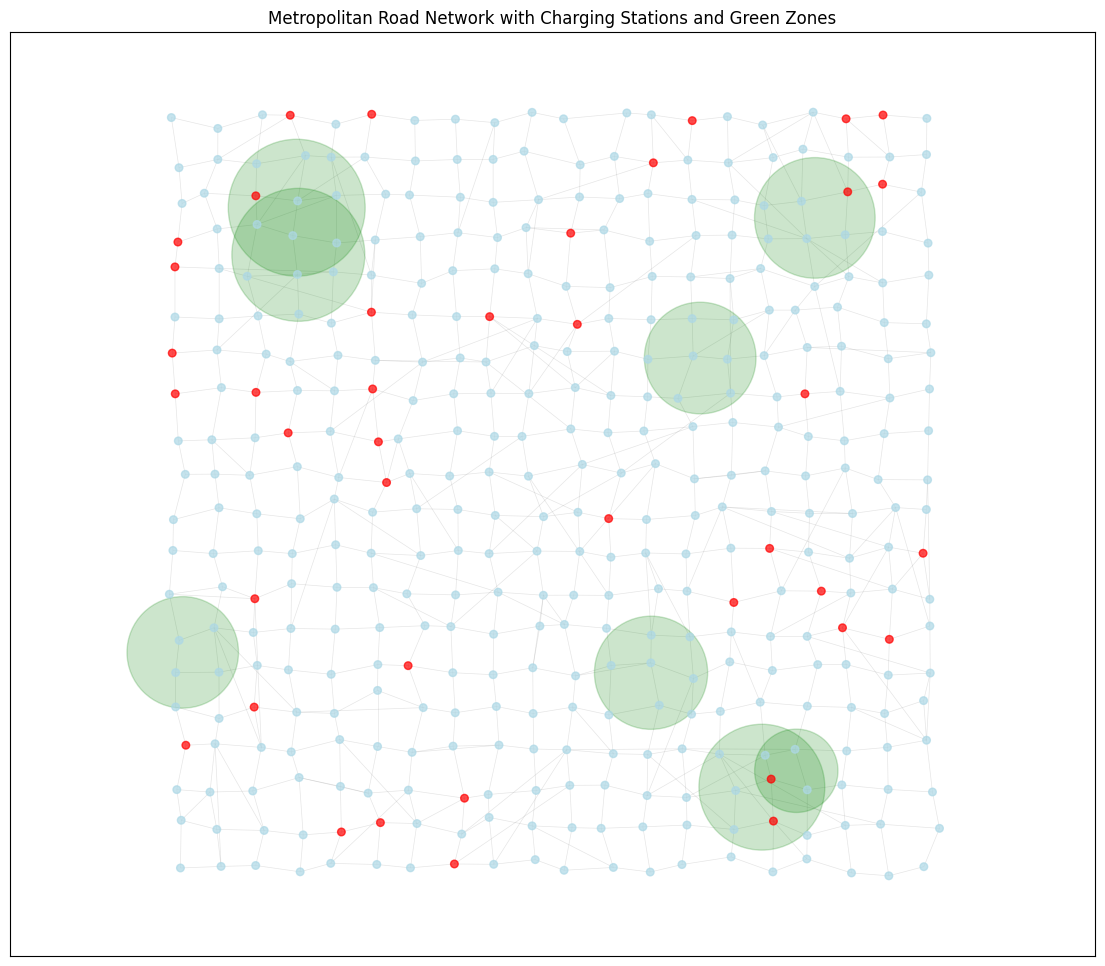

Selecting 10 O-D pairs with minimum distance of 5000 meters...

Processing O-D Pair #1: 396 → 313
Stopping search: maximum iterations reached --> 30
  Eco-Routing Energy:       0.189429 kWh, Cost: $80.06
  Shortest Path Energy:     0.815243 kWh, Cost: $60.19
  Fastest Path Energy:      1.177444 kWh, Cost: $70.26
  Heuristic Algorithm:      0.931861 kWh, Cost: $1020.78
  Heuristic vs. Eco:        -391.93% energy, -1175.00% cost

Processing O-D Pair #2: 241 → 376
Stopping search: maximum iterations reached --> 30
  Eco-Routing Energy:       0.475198 kWh, Cost: $140.19
  Shortest Path Energy:     4.056810 kWh, Cost: $140.83
  Fastest Path Energy:      2.269844 kWh, Cost: $150.52
  Heuristic Algorithm:      2.289908 kWh, Cost: $942.85
  Heuristic vs. Eco:        -381.88% energy, -572.55% cost

Processing O-D Pair #3: 372 → 31
Stopping search: maximum iterations reached --> 30
  Eco-Routing Energy:       0.241244 kWh, Cost: $180.14
  Shortest Path Energy:     0.661816 kWh, Cost: $150.21
  F

In [50]:
# Generate the metro road network with charging stations and green zones
city_network = generate_road_network(400, 1200, num_charging_stations=40, num_green_zones=8)

# Print network stats
print("\n")
print(f"=" * 40)
print(f"\nRoad Network with Charging Infrastructure:")
print(f"Number of intersections: {city_network.number_of_nodes()}")
print(f"Number of roads: {city_network.number_of_edges()}")
print(f"Number of charging stations: {sum(1 for n in city_network.nodes() if city_network.nodes[n]['charging_station'])}")
print(f"Number of green zones: {len(city_network.graph['green_zones'])}")

# Visualize the network with charging stations and green zones
plt.figure(figsize=(14, 12))
pos = nx.get_node_attributes(city_network, 'pos')

# Draw base network
nx.draw_networkx_edges(city_network, pos, alpha=0.2, width=0.5, edge_color='gray')

# Draw nodes with different colors for charging stations
node_colors = ['red' if city_network.nodes[n]['charging_station'] else 'lightblue' for n in city_network.nodes()]
nx.draw_networkx_nodes(city_network, pos, node_size=30, node_color=node_colors, alpha=0.7)

# Draw green zones as circles
for zone in city_network.graph['green_zones']:
    circle = plt.Circle(zone['center'], zone['radius'], color='green', alpha=0.2)
    plt.gca().add_patch(circle)

plt.title("Metropolitan Road Network with Charging Stations and Green Zones")
plt.axis('equal')
plt.show()

# Run a small test to see the heuristic algorithm in action
test_pairs = select_random_od_pairs(city_network, 10, 5000)
test_results = run_routing_comparison(city_network, test_pairs)

# Show the results
print("\n=== Test Results With Cost Metrics ===\n")
print(tabulate(test_results[["Pair ID", "Origin", "Destination",
                           "Eco-Routing Energy (kWh)", "Eco-Routing Cost ($)",
                           "Heuristic Energy (kWh)", "Heuristic Total Cost ($)",
                           "Heuristic Charging Stations Visited",
                           "Heuristic V2G Incentives ($)", "Heuristic Green Zone Penalties ($)",
                           "Heuristic vs Eco (%)"]],
              headers='keys', tablefmt='psql', showindex=False, floatfmt=".2f"))

Stopping search: maximum iterations reached --> 30


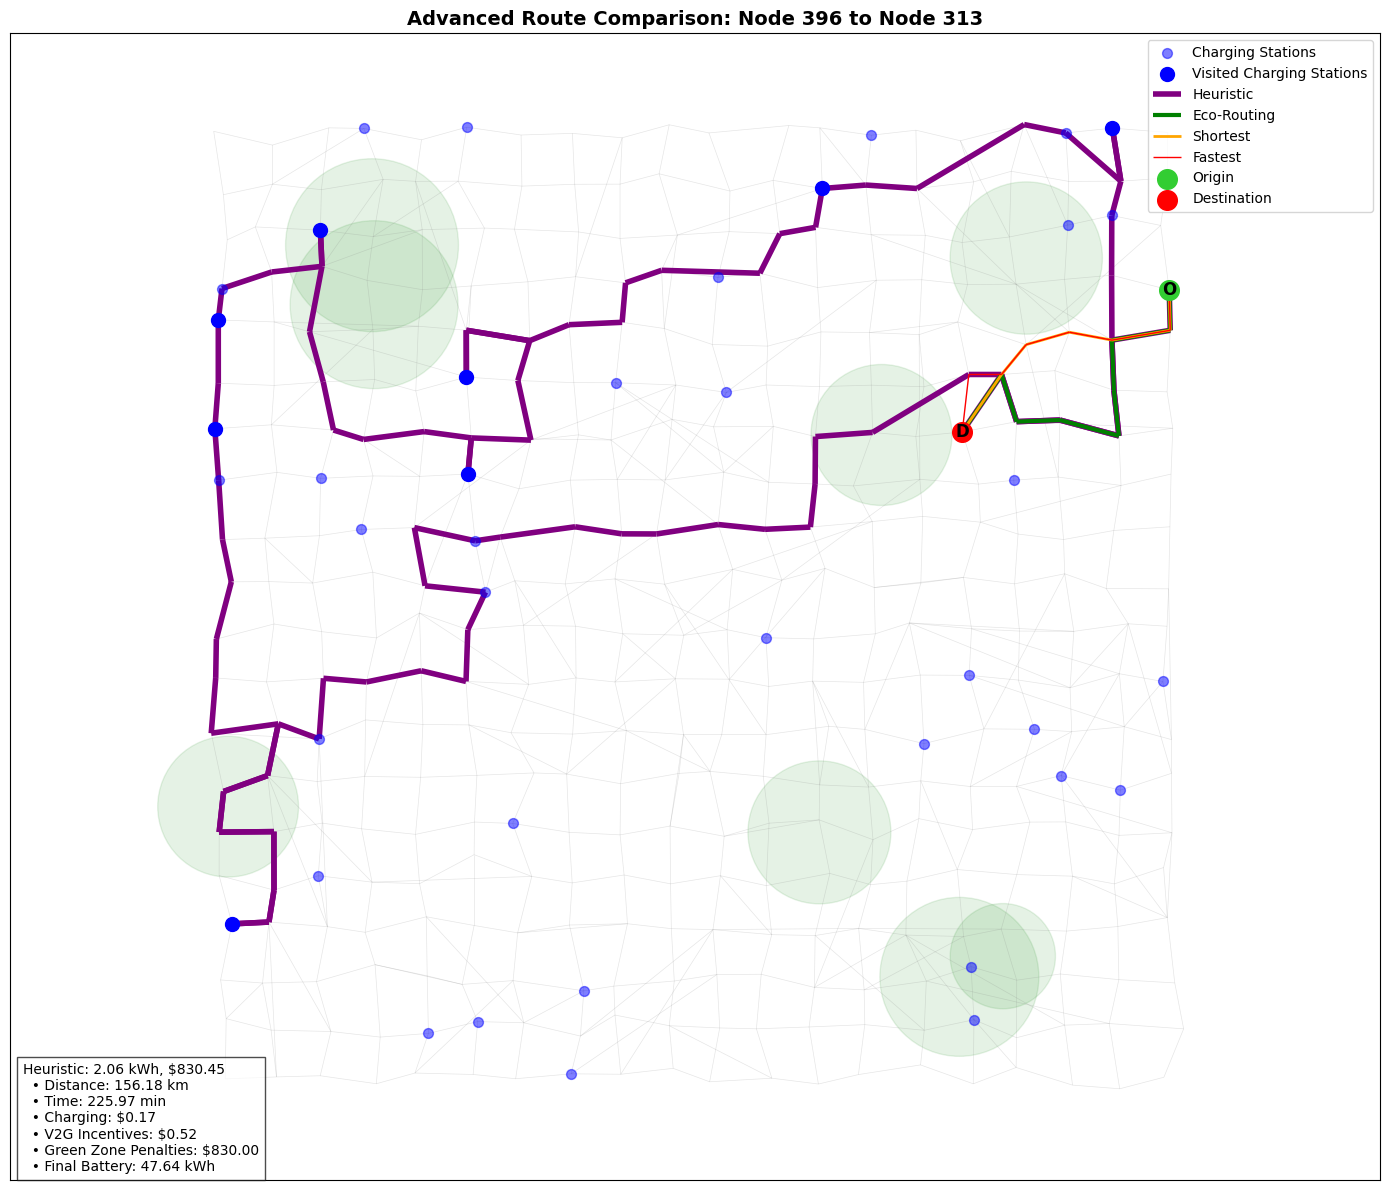

In [51]:
def visualize_advanced_route(graph, origin, destination, heuristic_path, eco_path,
                            shortest_path, fastest_path, metrics):
    """
    Visualize different routing paths with charging stations and green zones

    Parameters:
        graph (nx.Graph): Road network graph
        origin (int): Origin node ID
        destination (int): Destination node ID
        heuristic_path (list): Path from heuristic algorithm
        eco_path (list): Path from eco-routing algorithm
        shortest_path (list): Path from shortest path algorithm
        fastest_path (list): Path from fastest path algorithm
        metrics (dict): Metrics from heuristic algorithm
    """
    plt.figure(figsize=(14, 12))

    pos = nx.get_node_attributes(graph, 'pos')

    # Draw green zones first as background
    for zone in graph.graph['green_zones']:
        circle = plt.Circle(zone['center'], zone['radius'], color='green', alpha=0.1)
        plt.gca().add_patch(circle)

    # Draw the base network
    nx.draw_networkx_edges(graph, pos, alpha=0.2, width=0.5, edge_color='gray')

    # Draw charging stations (all charging stations in the network)
    charging_stations = [node for node in graph.nodes() if graph.nodes[node]['charging_station']]
    nx.draw_networkx_nodes(graph, pos, nodelist=charging_stations,
                          node_size=50, node_color='blue', alpha=0.5, label='Charging Stations')

    # Draw visited charging stations (from heuristic algorithm)
    visited_stations = metrics["charging_stations_visited"]
    if visited_stations:
        nx.draw_networkx_nodes(graph, pos, nodelist=visited_stations,
                              node_size=100, node_color='blue', alpha=1.0, label='Visited Charging Stations')

    # Draw different paths
    def get_path_edges(path):
        edges = []
        for i in range(len(path) - 1):
            edges.append((path[i], path[i+1]))
        return edges

    # Draw paths with different widths for visibility
    heuristic_edges = get_path_edges(heuristic_path)
    eco_edges = get_path_edges(eco_path)
    shortest_edges = get_path_edges(shortest_path)
    fastest_edges = get_path_edges(fastest_path)

    nx.draw_networkx_edges(graph, pos, edgelist=heuristic_edges, width=4, edge_color='purple', label='Heuristic')
    nx.draw_networkx_edges(graph, pos, edgelist=eco_edges, width=3, edge_color='green', label='Eco-Routing')
    nx.draw_networkx_edges(graph, pos, edgelist=shortest_edges, width=2, edge_color='orange', label='Shortest')
    nx.draw_networkx_edges(graph, pos, edgelist=fastest_edges, width=1, edge_color='red', label='Fastest')

    # Highlight origin and destination
    nx.draw_networkx_nodes(graph, pos, nodelist=[origin], node_size=200, node_color='limegreen', label='Origin')
    nx.draw_networkx_nodes(graph, pos, nodelist=[destination], node_size=200, node_color='red', label='Destination')

    # Add labels
    nx.draw_networkx_labels(graph, pos, labels={origin: "O", destination: "D"}, font_size=12, font_weight='bold')

    # Add metrics as text
    metrics_text = (
        f"Heuristic: {metrics['energy']:.2f} kWh, ${metrics['total_cost']:.2f}\n"
        f"  • Distance: {metrics['distance']/1000:.2f} km\n"
        f"  • Time: {metrics['time']/60:.2f} min\n"
        f"  • Charging: ${metrics['charging_cost']:.2f}\n"
        f"  • V2G Incentives: ${metrics['v2g_incentives']:.2f}\n"
        f"  • Green Zone Penalties: ${metrics['green_zone_penalties']:.2f}\n"
        f"  • Final Battery: {metrics['remaining_charge']:.2f} kWh"
    )

    plt.figtext(0.02, 0.02, metrics_text, bbox=dict(facecolor='white', alpha=0.7), fontsize=10)

    # Add legend and title
    plt.legend(fontsize=10, loc='upper right')
    plt.title(f'Advanced Route Comparison: Node {origin} to Node {destination}', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Visualize a sample route with all the new features
sample_pair = test_pairs[0]  # Get first O-D pair from test
origin, destination = sample_pair

# Run all algorithms
eco_path, _ = eco_routing_algorithm(city_network, origin, destination)
shortest_path, _ = shortest_path_distance(city_network, origin, destination)
fastest_path, _ = fastest_path_time(city_network, origin, destination)
heuristic_path, _, heuristic_metrics = heuristic_routing_algorithm(city_network, origin, destination)

# Visualize the routes
visualize_advanced_route(city_network, origin, destination,
                        heuristic_path, eco_path, shortest_path, fastest_path,
                        heuristic_metrics)

In [54]:
def generate_summary_statistics(results):
    """
    Generate summary statistics for the comparison results
    that handles both with and without heuristic algorithm data

    Parameters:
        results (pd.DataFrame): DataFrame with comparison results

    Returns:
        dict: Dictionary with summary statistics
    """
    # Check if heuristic data exists
    has_heuristic = 'Heuristic Energy (kWh)' in results.columns

    summary = {
        "Number of O-D Pairs": len(results),

        "Average Energy Consumption (kWh)": {
            "Eco-Routing": results["Eco-Routing Energy (kWh)"].mean(),
            "Shortest Path": results["Shortest Energy (kWh)"].mean(),
            "Fastest Path": results["Fastest Energy (kWh)"].mean(),
        },

        "Average Path Distance (m)": {
            "Eco-Routing": results["Eco-Routing Distance (m)"].mean(),
            "Shortest Path": results["Shortest Distance (m)"].mean(),
            "Fastest Path": results["Fastest Distance (m)"].mean(),
        },

        "Average Travel Time (s)": {
            "Eco-Routing": results["Eco-Routing Time (s)"].mean(),
            "Shortest Path": results["Shortest Time (s)"].mean(),
            "Fastest Path": results["Fastest Time (s)"].mean(),
        },

        "Average Energy Savings (%)": {
            "vs. Shortest Path": results["Eco vs Shortest (%)"].mean(),
            "vs. Fastest Path": results["Eco vs Fastest (%)"].mean()
        }
    }

    # Add heuristic data if available
    if has_heuristic:
        # Add to existing dictionaries
        summary["Average Energy Consumption (kWh)"]["Heuristic"] = results["Heuristic Energy (kWh)"].mean()
        summary["Average Path Distance (m)"]["Heuristic"] = results["Heuristic Distance (m)"].mean()
        summary["Average Travel Time (s)"]["Heuristic"] = results["Heuristic Time (s)"].mean()

        # Add new metrics
        summary["Average Total Cost ($)"] = {
            "Eco-Routing": results["Eco-Routing Cost ($)"].mean() if "Eco-Routing Cost ($)" in results.columns else 0,
            "Shortest Path": results["Shortest Cost ($)"].mean() if "Shortest Cost ($)" in results.columns else 0,
            "Fastest Path": results["Fastest Cost ($)"].mean() if "Fastest Cost ($)" in results.columns else 0,
            "Heuristic": results["Heuristic Total Cost ($)"].mean()
        }

        summary["Average Energy Savings (%)"].update({
            "Heuristic vs Shortest": results["Heuristic vs Shortest (%)"].mean(),
            "Heuristic vs Fastest": results["Heuristic vs Fastest (%)"].mean(),
            "Heuristic vs Eco": results["Heuristic vs Eco (%)"].mean()
        })

        summary["Average Cost Savings (%)"] = {
            "Heuristic vs Shortest": results["Cost: Heuristic vs Shortest (%)"].mean() if "Cost: Heuristic vs Shortest (%)" in results.columns else 0,
            "Heuristic vs Fastest": results["Cost: Heuristic vs Fastest (%)"].mean() if "Cost: Heuristic vs Fastest (%)" in results.columns else 0,
            "Heuristic vs Eco": results["Cost: Heuristic vs Eco (%)"].mean() if "Cost: Heuristic vs Eco (%)" in results.columns else 0
        }

        summary["Heuristic Algorithm Metrics"] = {
            "Average Charging Cost ($)": results["Heuristic Charging Cost ($)"].mean(),
            "Average V2G Incentives ($)": results["Heuristic V2G Incentives ($)"].mean(),
            "Average Green Zone Penalties ($)": results["Heuristic Green Zone Penalties ($)"].mean(),
            "Average Charging Stations Visited": results["Heuristic Charging Stations Visited"].mean(),
            "Average Remaining Charge (kWh)": results["Heuristic Remaining Charge (kWh)"].mean()
        }

    return summary

# Print summary statistics with error handling
def print_summary_statistics(summary_stats):
    """Print summary statistics with conditional sections based on available data"""
    print("\n" + "="*80)
    print("ROUTING ALGORITHM COMPARISON")
    print("="*80)

    print(f"\nNumber of O-D Pairs: {summary_stats['Number of O-D Pairs']}")

    print("\n" + "-"*40)
    print("ENERGY CONSUMPTION & SAVINGS")
    print("-"*40)

    print("\nAverage Energy Consumption (kWh):")
    for algo, value in summary_stats["Average Energy Consumption (kWh)"].items():
        print(f"  {algo}: {value:.6f} kWh")

    print("\nAverage Energy Savings (%):")
    for algo, value in summary_stats["Average Energy Savings (%)"].items():
        print(f"  {algo}: {value:.2f}%")

    print("\nAverage Path Distance (m):")
    for algo, value in summary_stats["Average Path Distance (m)"].items():
        print(f"  {algo}: {value:.2f} m")

    print("\nAverage Travel Time (s):")
    for algo, value in summary_stats["Average Travel Time (s)"].items():
        print(f"  {algo}: {value:.2f} s")

    # Only print cost section if heuristic data is available
    if "Average Total Cost ($)" in summary_stats:
        print("\n" + "-"*40)
        print("COST ANALYSIS")
        print("-"*40)

        print("\nAverage Total Cost ($):")
        for algo, value in summary_stats["Average Total Cost ($)"].items():
            print(f"  {algo}: ${value:.2f}")

        print("\nAverage Cost Savings (%):")
        for algo, value in summary_stats["Average Cost Savings (%)"].items():
            print(f"  {algo}: {value:.2f}%")

    # Only print heuristic details if available
    if "Heuristic Algorithm Metrics" in summary_stats:
        print("\n" + "-"*40)
        print("HEURISTIC ALGORITHM DETAILED METRICS")
        print("-"*40)

        for metric, value in summary_stats["Heuristic Algorithm Metrics"].items():
            if "Cost" in metric or "Incentives" in metric or "Penalties" in metric:
                print(f"  {metric}: ${value:.2f}")
            else:
                print(f"  {metric}: {value:.2f}")

# Generate and print summary statistics
try:
    summary_stats = generate_summary_statistics(comparison_results)
    print_summary_statistics(summary_stats)
except Exception as e:
    print(f"Error generating summary statistics: {e}")
    print("Please run the routing comparison with the heuristic algorithm first.")


ROUTING ALGORITHM COMPARISON

Number of O-D Pairs: 5

----------------------------------------
ENERGY CONSUMPTION & SAVINGS
----------------------------------------

Average Energy Consumption (kWh):
  Eco-Routing: 0.680312 kWh
  Shortest Path: 0.694474 kWh
  Fastest Path: 0.832228 kWh

Average Energy Savings (%):
  vs. Shortest Path: 1.67%
  vs. Fastest Path: 19.05%

Average Path Distance (m):
  Eco-Routing: 8880.94 m
  Shortest Path: 8751.11 m
  Fastest Path: 9287.35 m

Average Travel Time (s):
  Eco-Routing: 804.93 s
  Shortest Path: 754.38 s
  Fastest Path: 727.89 s


In [55]:
def run_large_scale_simulation(graph, num_pairs=2000, batch_size=100, min_distance=3000):
    """
    Run a large-scale simulation with many origin-destination pairs,
    including the new heuristic algorithm with charging stations and green zones.

    Parameters:
        graph (nx.Graph): Road network graph
        num_pairs (int): Total number of O-D pairs to simulate
        batch_size (int): Number of pairs to process in each batch
        min_distance (float): Minimum distance between origin and destination

    Returns:
        pd.DataFrame: Aggregated results
    """
    print(f"Starting large-scale simulation with {num_pairs} O-D pairs...")
    start_time = datetime.now()

    # Generate all O-D pairs first
    print("Generating origin-destination pairs...")
    all_od_pairs = select_random_od_pairs(graph, num_pairs, min_distance)
    print(f"Generated {len(all_od_pairs)} origin-destination pairs")

    # Process in batches
    all_results = []
    num_batches = (num_pairs + batch_size - 1) // batch_size  # Ceiling division

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, len(all_od_pairs))
        batch_pairs = all_od_pairs[batch_start:batch_end]

        print(f"\nProcessing batch {batch_idx + 1}/{num_batches} ({batch_end - batch_start} pairs)")

        # Run comparison for this batch
        batch_results = run_routing_comparison(graph, batch_pairs)
        all_results.append(batch_results)

        # Print progress
        pairs_processed = batch_end
        elapsed_time = (datetime.now() - start_time).total_seconds()
        pairs_per_second = pairs_processed / elapsed_time if elapsed_time > 0 else 0
        estimated_total = elapsed_time * (num_pairs / pairs_processed) if pairs_processed > 0 else 0
        remaining_time = estimated_total - elapsed_time

        print(f"Progress: {pairs_processed}/{min(num_pairs, len(all_od_pairs))} pairs processed ({pairs_processed/min(num_pairs, len(all_od_pairs))*100:.1f}%)")
        print(f"Processing speed: {pairs_per_second:.2f} pairs/second")
        print(f"Elapsed time: {elapsed_time/60:.1f} minutes")
        print(f"Estimated remaining time: {remaining_time/60:.1f} minutes")

        # Calculate batch stats for quick feedback
        if batch_idx % 2 == 0 and batch_idx > 0:
            interim_results = pd.concat(all_results, ignore_index=True)
            print("\nInterim results after", pairs_processed, "pairs:")

            # Get average energy for each algorithm
            print("Avg Energy (kWh): Eco =", f"{interim_results['Eco-Routing Energy (kWh)'].mean():.4f}",
                  "Shortest =", f"{interim_results['Shortest Energy (kWh)'].mean():.4f}",
                  "Fastest =", f"{interim_results['Fastest Energy (kWh)'].mean():.4f}")

            # If we have heuristic data
            if 'Heuristic Energy (kWh)' in interim_results.columns:
                print("Heuristic =", f"{interim_results['Heuristic Energy (kWh)'].mean():.4f}",
                      "with avg cost", f"${interim_results['Heuristic Total Cost ($)'].mean():.2f}")

    # Combine all results
    combined_results = pd.concat(all_results, ignore_index=True)

    # Calculate overall statistics
    print("\nCalculating overall statistics...")
    summary_stats = generate_summary_statistics(combined_results)

    # Print summary
    print("\n=== Overall Simulation Results ===\n")
    print(f"Total O-D pairs processed: {len(combined_results)}")

    print("\nAverage Energy Consumption (kWh):")
    for algo, value in summary_stats["Average Energy Consumption (kWh)"].items():
        print(f"  {algo}: {value:.6f} kWh")

    print("\nAverage Energy Savings (%):")
    for algo, value in summary_stats["Average Energy Savings (%)"].items():
        print(f"  {algo}: {value:.2f}%")

    # If we have heuristic data
    if "Average Total Cost ($)" in summary_stats:
        print("\nAverage Total Cost ($):")
        for algo, value in summary_stats["Average Total Cost ($)"].items():
            print(f"  {algo}: ${value:.2f}")

        print("\nAverage Cost Savings (%):")
        for algo, value in summary_stats["Average Cost Savings (%)"].items():
            print(f"  {algo}: {value:.2f}%")

    # Generate overall visualizations
    visualize_simulation_results(summary_stats, combined_results)

    # Calculate more detailed statistics
    detailed_stats = {
        "Energy Savings vs Shortest": {
            "Mean": combined_results["Eco vs Shortest (%)"].mean(),
            "Median": combined_results["Eco vs Shortest (%)"].median(),
            "Std Dev": combined_results["Eco vs Shortest (%)"].std(),
            "Min": combined_results["Eco vs Shortest (%)"].min(),
            "Max": combined_results["Eco vs Shortest (%)"].max(),
            "25th Percentile": np.percentile(combined_results["Eco vs Shortest (%)"], 25),
            "75th Percentile": np.percentile(combined_results["Eco vs Shortest (%)"], 75)
        },
        "Energy Savings vs Fastest": {
            "Mean": combined_results["Eco vs Fastest (%)"].mean(),
            "Median": combined_results["Eco vs Fastest (%)"].median(),
            "Std Dev": combined_results["Eco vs Fastest (%)"].std(),
            "Min": combined_results["Eco vs Fastest (%)"].min(),
            "Max": combined_results["Eco vs Fastest (%)"].max(),
            "25th Percentile": np.percentile(combined_results["Eco vs Fastest (%)"], 25),
            "75th Percentile": np.percentile(combined_results["Eco vs Fastest (%)"], 75)
        }
    }

    # Add heuristic detailed stats if available
    if "Heuristic vs Eco (%)" in combined_results.columns:
        detailed_stats["Heuristic Energy Savings vs Eco"] = {
            "Mean": combined_results["Heuristic vs Eco (%)"].mean(),
            "Median": combined_results["Heuristic vs Eco (%)"].median(),
            "Std Dev": combined_results["Heuristic vs Eco (%)"].std(),
            "Min": combined_results["Heuristic vs Eco (%)"].min(),
            "Max": combined_results["Heuristic vs Eco (%)"].max(),
            "25th Percentile": np.percentile(combined_results["Heuristic vs Eco (%)"], 25),
            "75th Percentile": np.percentile(combined_results["Heuristic vs Eco (%)"], 75)
        }

        detailed_stats["Cost Savings: Heuristic vs Eco"] = {
            "Mean": combined_results["Cost: Heuristic vs Eco (%)"].mean(),
            "Median": combined_results["Cost: Heuristic vs Eco (%)"].median(),
            "Std Dev": combined_results["Cost: Heuristic vs Eco (%)"].std(),
            "Min": combined_results["Cost: Heuristic vs Eco (%)"].min(),
            "Max": combined_results["Cost: Heuristic vs Eco (%)"].max(),
            "25th Percentile": np.percentile(combined_results["Cost: Heuristic vs Eco (%)"], 25),
            "75th Percentile": np.percentile(combined_results["Cost: Heuristic vs Eco (%)"], 75)
        }

    print("\n=== Detailed Statistics ===\n")

    for category, stats in detailed_stats.items():
        print(f"\n{category}:")
        for stat, value in stats.items():
            print(f"  {stat}: {value:.2f}%")

    # Final timing
    total_time = (datetime.now() - start_time).total_seconds()
    print(f"\nTotal simulation time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

    # Save results to CSV
    result_filename = f"eco_routing_simulation_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    combined_results.to_csv(result_filename, index=False)
    print(f"\nFull results saved to {result_filename}")

    return combined_results

def visualize_simulation_results(summary_stats, combined_results):
    """
    Create comprehensive visualizations for simulation results

    Parameters:
        summary_stats (dict): Dictionary with summary statistics
        combined_results (pd.DataFrame): DataFrame with all simulation results
    """
    # Determine available algorithms
    algorithms = list(summary_stats["Average Energy Consumption (kWh)"].keys())
    has_heuristic = "Heuristic" in algorithms

    # Set colors based on available algorithms
    colors = ['green', 'orange', 'red']
    if has_heuristic:
        colors.append('purple')

    # Figure 1: Energy consumption and distance
    plt.figure(figsize=(14, 6))

    # 1A. ENERGY CONSUMPTION
    plt.subplot(1, 2, 1)
    energy_values = [summary_stats["Average Energy Consumption (kWh)"][algo] for algo in algorithms]
    bars = plt.bar(algorithms, energy_values, color=colors)
    plt.title('Average Energy Consumption', fontsize=14, fontweight='bold')
    plt.ylabel('Energy (kWh)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 1B. DISTANCE COMPARISON
    plt.subplot(1, 2, 2)
    distance_values = [summary_stats["Average Path Distance (m)"][algo]/1000 for algo in algorithms]  # Convert to km
    bars = plt.bar(algorithms, distance_values, color=colors)
    plt.title('Average Path Distance', fontsize=14, fontweight='bold')
    plt.ylabel('Distance (km)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Figure 2: Energy savings distribution histograms
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.hist(combined_results["Eco vs Shortest (%)"], bins=50, alpha=0.7, color='orange')
    plt.title('Distribution of Energy Savings: Eco-Routing vs. Shortest Path', fontsize=12)
    plt.xlabel('Energy Savings (%)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.hist(combined_results["Eco vs Fastest (%)"], bins=50, alpha=0.7, color='red')
    plt.title('Distribution of Energy Savings: Eco-Routing vs. Fastest Path', fontsize=12)
    plt.xlabel('Energy Savings (%)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Figure 3: If heuristic data is available
    if has_heuristic:
        plt.figure(figsize=(14, 10))

        # 3A. COST COMPARISON
        plt.subplot(2, 2, 1)
        cost_values = [summary_stats["Average Total Cost ($)"][algo] for algo in algorithms]
        bars = plt.bar(algorithms, cost_values, color=colors)
        plt.title('Average Total Cost', fontsize=14, fontweight='bold')
        plt.ylabel('Cost ($)', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'${height:.2f}',
                     ha='center', va='bottom', fontweight='bold', fontsize=9)

        # 3B. HEURISTIC vs ECO ENERGY SAVINGS
        plt.subplot(2, 2, 2)
        plt.hist(combined_results["Heuristic vs Eco (%)"], bins=40, alpha=0.7, color='purple')
        plt.title('Energy Savings: Heuristic vs. Eco-Routing', fontsize=12)
        plt.xlabel('Energy Savings (%)')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)

        # 3C. COST SAVINGS
        plt.subplot(2, 2, 3)
        plt.hist(combined_results["Cost: Heuristic vs Eco (%)"], bins=40, alpha=0.7, color='green')
        plt.title('Cost Savings: Heuristic vs. Eco-Routing', fontsize=12)
        plt.xlabel('Cost Savings (%)')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)

        # 3D. HEURISTIC METRICS BREAKDOWN
        heuristic_metrics = ["Energy\nCost", "Charging\nCost", "V2G\nIncentives", "Green Zone\nPenalties"]
        heuristic_values = [
            summary_stats["Average Total Cost ($)"]["Heuristic"] -
            summary_stats["Heuristic Algorithm Metrics"]["Average Charging Cost ($)"] +
            summary_stats["Heuristic Algorithm Metrics"]["Average V2G Incentives ($)"] -
            summary_stats["Heuristic Algorithm Metrics"]["Average Green Zone Penalties ($)"],
            summary_stats["Heuristic Algorithm Metrics"]["Average Charging Cost ($)"],
            -summary_stats["Heuristic Algorithm Metrics"]["Average V2G Incentives ($)"],
            summary_stats["Heuristic Algorithm Metrics"]["Average Green Zone Penalties ($)"]
        ]

        plt.subplot(2, 2, 4)
        heuristic_colors = ['blue', 'orange', 'green', 'red']
        bars = plt.bar(heuristic_metrics, heuristic_values, color=heuristic_colors)
        plt.title('Heuristic Algorithm Cost Breakdown', fontsize=12)
        plt.ylabel('Amount ($)', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'${abs(height):.2f}',
                     ha='center', va='bottom' if height >= 0 else 'top',
                     fontweight='bold', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Figure 4: Additional Heuristic Analysis - Charging Stations Visited
        plt.figure(figsize=(10, 6))
        plt.hist(combined_results["Heuristic Charging Stations Visited"], bins=range(0, int(combined_results["Heuristic Charging Stations Visited"].max())+2),
                 alpha=0.7, color='blue', rwidth=0.8)
        plt.title('Distribution of Charging Stations Visited', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Charging Stations')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)
        plt.xticks(range(0, int(combined_results["Heuristic Charging Stations Visited"].max())+1))
        plt.tight_layout()
        plt.show()

In [57]:
test_pairs = select_random_od_pairs(city_network, 20, 2000)
test_results = run_routing_comparison(city_network, test_pairs)

Selecting 20 O-D pairs with minimum distance of 2000 meters...

Processing O-D Pair #1: 151 → 188
Stopping search: maximum iterations reached --> 30
  Eco-Routing Energy:       0.242228 kWh, Cost: $50.07
  Shortest Path Energy:     0.960393 kWh, Cost: $40.19
  Fastest Path Energy:      0.744340 kWh, Cost: $40.17
  Heuristic Algorithm:      0.948583 kWh, Cost: $532.17
  Heuristic vs. Eco:        -291.61% energy, -962.88% cost

Processing O-D Pair #2: 314 → 113
Stopping search: maximum iterations reached --> 30
  Eco-Routing Energy:       0.139864 kWh, Cost: $110.06
  Shortest Path Energy:     1.362816 kWh, Cost: $60.30
  Fastest Path Energy:      1.362816 kWh, Cost: $60.30
  Heuristic Algorithm:      1.376065 kWh, Cost: $1181.98
  Heuristic vs. Eco:        -883.86% energy, -973.90% cost

Processing O-D Pair #3: 112 → 68
Stopping search: maximum iterations reached --> 30
  Eco-Routing Energy:       -0.017645 kWh, Cost: $140.04
  Shortest Path Energy:     1.174719 kWh, Cost: $40.23
  Fast

In [58]:
# Display comprehensive results table
print("\n=== Comprehensive Test Results ===\n")

# Show basic energy comparison across all algorithms
print("ENERGY CONSUMPTION AND SAVINGS:")
print(tabulate(test_results[["Pair ID", "Origin", "Destination",
                           "Eco-Routing Energy (kWh)", "Shortest Energy (kWh)",
                           "Fastest Energy (kWh)", "Heuristic Energy (kWh)",
                           "Eco vs Shortest (%)", "Eco vs Fastest (%)",
                           "Heuristic vs Eco (%)"]],
              headers='keys', tablefmt='psql', showindex=False, floatfmt=".6f"))


=== Comprehensive Test Results ===

ENERGY CONSUMPTION AND SAVINGS:
+-----------+------------+---------------+----------------------------+-------------------------+------------------------+--------------------------+-----------------------+----------------------+------------------------+
|   Pair ID |     Origin |   Destination |   Eco-Routing Energy (kWh) |   Shortest Energy (kWh) |   Fastest Energy (kWh) |   Heuristic Energy (kWh) |   Eco vs Shortest (%) |   Eco vs Fastest (%) |   Heuristic vs Eco (%) |
|-----------+------------+---------------+----------------------------+-------------------------+------------------------+--------------------------+-----------------------+----------------------+------------------------|
|  1.000000 | 151.000000 |    188.000000 |                   0.242228 |                0.960393 |               0.744340 |                 0.948583 |             74.778261 |            67.457376 |            -291.607962 |
|  2.000000 | 314.000000 |    113.000000 | 

In [59]:
# Display cost-related metrics
print("\nCOST ANALYSIS:")
print(tabulate(test_results[["Pair ID",
                           "Eco-Routing Cost ($)", "Shortest Cost ($)",
                           "Fastest Cost ($)", "Heuristic Total Cost ($)",
                           "Heuristic Charging Cost ($)", "Heuristic V2G Incentives ($)",
                           "Heuristic Green Zone Penalties ($)",
                           "Cost: Heuristic vs Eco (%)"]],
              headers='keys', tablefmt='psql', showindex=False, floatfmt=".2f"))


COST ANALYSIS:
+-----------+------------------------+---------------------+--------------------+----------------------------+-------------------------------+--------------------------------+--------------------------------------+------------------------------+
|   Pair ID |   Eco-Routing Cost ($) |   Shortest Cost ($) |   Fastest Cost ($) |   Heuristic Total Cost ($) |   Heuristic Charging Cost ($) |   Heuristic V2G Incentives ($) |   Heuristic Green Zone Penalties ($) |   Cost: Heuristic vs Eco (%) |
|-----------+------------------------+---------------------+--------------------+----------------------------+-------------------------------+--------------------------------+--------------------------------------+------------------------------|
|      1.00 |                  50.07 |               40.19 |              40.17 |                     532.17 |                          5.16 |                           3.57 |                               530.00 |                      -962.88 |


In [60]:
# Display charging station information
print("\nCHARGING INFRASTRUCTURE USAGE:")
print(tabulate(test_results[["Pair ID",
                           "Heuristic Charging Stations Visited",
                           "Eco-Routing Remaining Charge (kWh)",
                           "Heuristic Remaining Charge (kWh)"]],
              headers='keys', tablefmt='psql', showindex=False, floatfmt=".2f"))


CHARGING INFRASTRUCTURE USAGE:
+-----------+---------------------------------------+--------------------------------------+------------------------------------+
|   Pair ID |   Heuristic Charging Stations Visited |   Eco-Routing Remaining Charge (kWh) |   Heuristic Remaining Charge (kWh) |
|-----------+---------------------------------------+--------------------------------------+------------------------------------|
|      1.00 |                                  8.00 |                                54.76 |                              47.88 |
|      2.00 |                                 13.00 |                                54.86 |                              48.15 |
|      3.00 |                                 13.00 |                                55.02 |                              47.52 |
|      4.00 |                                 12.00 |                                55.08 |                              47.99 |
|      5.00 |                                 12.00 |     


SUMMARY OF AVERAGE IMPROVEMENTS ACROSS ALL TEST PAIRS

ENERGY CONSUMPTION:
• Average energy savings vs. Shortest Path: 54.40%
• Average energy savings vs. Fastest Path:  81.84%
• Heuristic vs Eco-Routing energy improvement: -1406.51%

COST EFFICIENCY:
• Heuristic vs Eco-Routing cost savings: -92685.59%

TRAVEL TIME TRADE-OFFS:
• Eco-routing takes 52.84% longer than Shortest Path
• Eco-routing takes 71.56% longer than Fastest Path
• Heuristic takes 1285.90% longer than Eco-Routing

CHARGING INFRASTRUCTURE:
• Average charging stations visited: 11.50
• Percentage of routes using charging: 100.0%


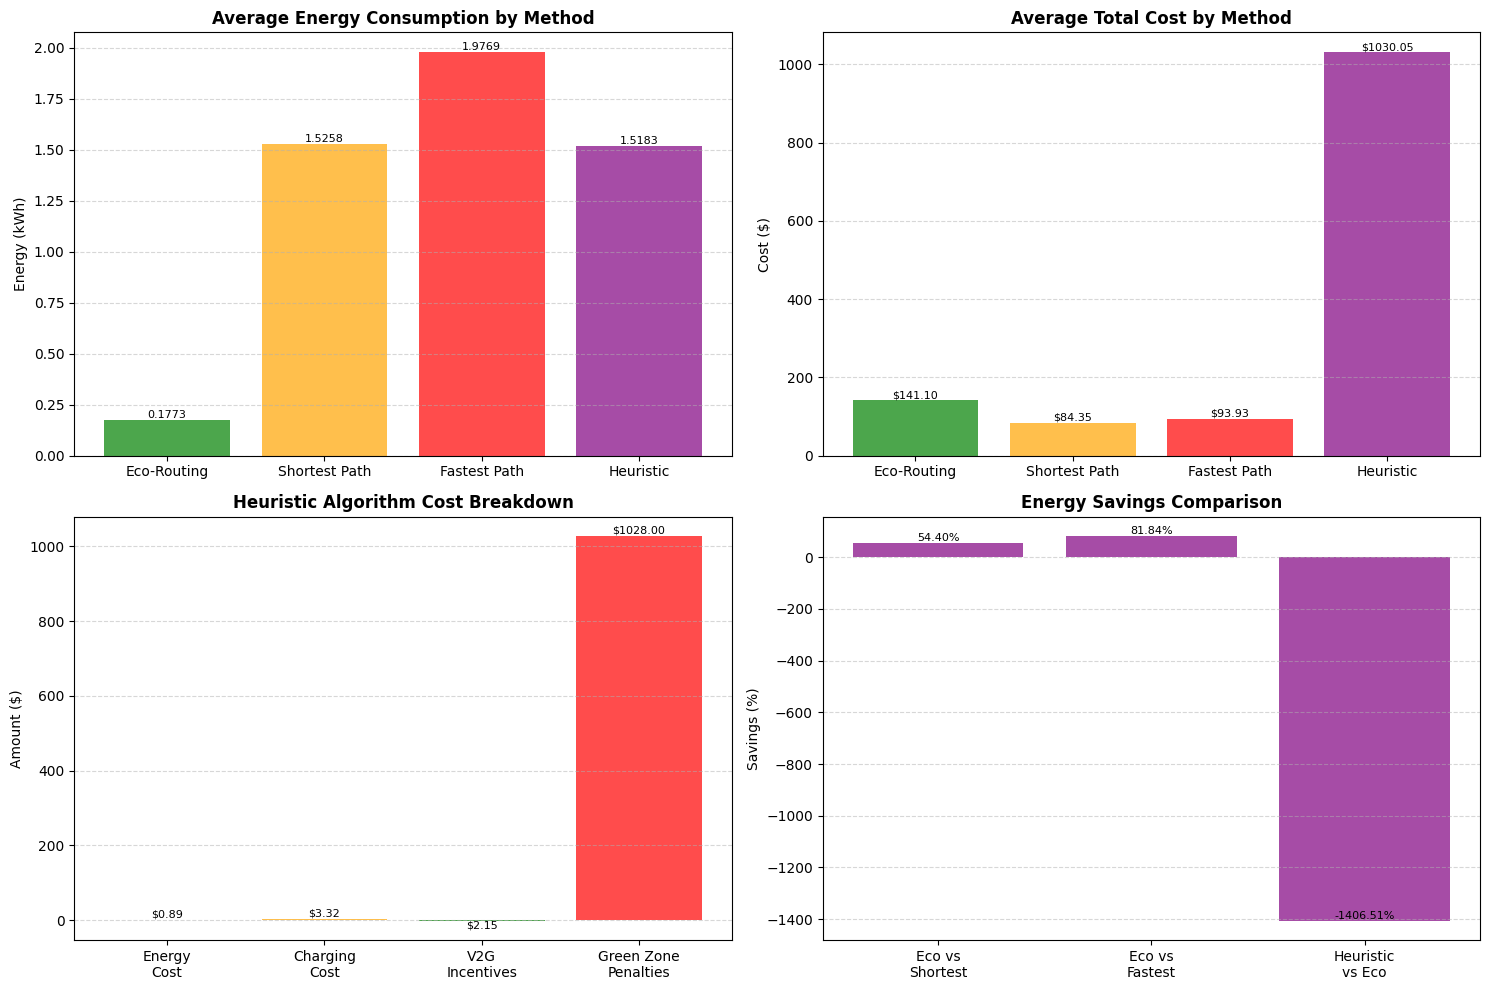


Full results saved to 'eco_routing_simulation_results.csv'
Summary statistics saved to 'eco_routing_summary.csv'


In [62]:
# Calculate average improvements
avg_energy_savings_vs_shortest = test_results["Eco vs Shortest (%)"].mean()
avg_energy_savings_vs_fastest = test_results["Eco vs Fastest (%)"].mean()
avg_heuristic_vs_eco_energy = test_results["Heuristic vs Eco (%)"].mean()
avg_heuristic_vs_eco_cost = test_results["Cost: Heuristic vs Eco (%)"].mean()

# Calculate time differences (positive values mean eco-routing takes longer)
test_results["Time Diff vs Shortest (%)"] = ((test_results["Eco-Routing Time (s)"] / test_results["Shortest Time (s)"]) - 1) * 100
test_results["Time Diff vs Fastest (%)"] = ((test_results["Eco-Routing Time (s)"] / test_results["Fastest Time (s)"]) - 1) * 100
test_results["Heuristic Time Diff vs Eco (%)"] = ((test_results["Heuristic Time (s)"] / test_results["Eco-Routing Time (s)"]) - 1) * 100

avg_time_diff_vs_shortest = test_results["Time Diff vs Shortest (%)"].mean()
avg_time_diff_vs_fastest = test_results["Time Diff vs Fastest (%)"].mean()
avg_heuristic_time_diff_vs_eco = test_results["Heuristic Time Diff vs Eco (%)"].mean()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY OF AVERAGE IMPROVEMENTS ACROSS ALL TEST PAIRS")
print("="*80)

# Energy savings
print("\nENERGY CONSUMPTION:")
print(f"• Average energy savings vs. Shortest Path: {avg_energy_savings_vs_shortest:.2f}%")
print(f"• Average energy savings vs. Fastest Path:  {avg_energy_savings_vs_fastest:.2f}%")
print(f"• Heuristic vs Eco-Routing energy improvement: {avg_heuristic_vs_eco_energy:.2f}%")

# Cost savings
print("\nCOST EFFICIENCY:")
print(f"• Heuristic vs Eco-Routing cost savings: {avg_heuristic_vs_eco_cost:.2f}%")

# Time differences
print("\nTRAVEL TIME TRADE-OFFS:")
if avg_time_diff_vs_shortest > 0:
    print(f"• Eco-routing takes {avg_time_diff_vs_shortest:.2f}% longer than Shortest Path")
else:
    print(f"• Eco-routing is {abs(avg_time_diff_vs_shortest):.2f}% faster than Shortest Path")

if avg_time_diff_vs_fastest > 0:
    print(f"• Eco-routing takes {avg_time_diff_vs_fastest:.2f}% longer than Fastest Path")
else:
    print(f"• Eco-routing is {abs(avg_time_diff_vs_fastest):.2f}% faster than Fastest Path")

if avg_heuristic_time_diff_vs_eco > 0:
    print(f"• Heuristic takes {avg_heuristic_time_diff_vs_eco:.2f}% longer than Eco-Routing")
else:
    print(f"• Heuristic is {abs(avg_heuristic_time_diff_vs_eco):.2f}% faster than Eco-Routing")

# Infrastructure usage
avg_charging_stations = test_results["Heuristic Charging Stations Visited"].mean()
print(f"\nCHARGING INFRASTRUCTURE:")
print(f"• Average charging stations visited: {avg_charging_stations:.2f}")
print(f"• Percentage of routes using charging: {(test_results['Heuristic Charging Stations Visited'] > 0).mean() * 100:.1f}%")
# Visualize key comparisons
plt.figure(figsize=(15, 10))

# Create a 2x2 grid of visualizations
# 1. Energy consumption comparison
plt.subplot(2, 2, 1)
algorithms = ["Eco-Routing", "Shortest Path", "Fastest Path", "Heuristic"]
energy_values = [
    test_results["Eco-Routing Energy (kWh)"].mean(),
    test_results["Shortest Energy (kWh)"].mean(),
    test_results["Fastest Energy (kWh)"].mean(),
    test_results["Heuristic Energy (kWh)"].mean()
]
colors = ['green', 'orange', 'red', 'purple']
bars = plt.bar(algorithms, energy_values, color=colors, alpha=0.7)
plt.title('Average Energy Consumption by Method', fontsize=12, fontweight='bold')
plt.ylabel('Energy (kWh)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=8)

# 2. Cost comparison
plt.subplot(2, 2, 2)
cost_values = [
    test_results["Eco-Routing Cost ($)"].mean(),
    test_results["Shortest Cost ($)"].mean(),
    test_results["Fastest Cost ($)"].mean(),
    test_results["Heuristic Total Cost ($)"].mean()
]
bars = plt.bar(algorithms, cost_values, color=colors, alpha=0.7)
plt.title('Average Total Cost by Method', fontsize=12, fontweight='bold')
plt.ylabel('Cost ($)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.2f}',
             ha='center', va='bottom', fontsize=8)

# 3. Heuristic cost breakdown
plt.subplot(2, 2, 3)
components = ['Energy\nCost', 'Charging\nCost', 'V2G\nIncentives', 'Green Zone\nPenalties']
breakdown_values = [
    test_results["Heuristic Energy Cost ($)"].mean(),
    test_results["Heuristic Charging Cost ($)"].mean(),
    -test_results["Heuristic V2G Incentives ($)"].mean(),  # Negative for visual clarity
    test_results["Heuristic Green Zone Penalties ($)"].mean()
]
breakdown_colors = ['blue', 'orange', 'green', 'red']
bars = plt.bar(components, breakdown_values, color=breakdown_colors, alpha=0.7)
plt.title('Heuristic Algorithm Cost Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Amount ($)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${abs(height):.2f}',
             ha='center', va='bottom' if height >= 0 else 'top',
             fontsize=8)

# 4. Energy savings comparison
plt.subplot(2, 2, 4)
savings_categories = ['Eco vs\nShortest', 'Eco vs\nFastest', 'Heuristic\nvs Eco']
savings_values = [
    avg_energy_savings_vs_shortest,
    avg_energy_savings_vs_fastest,
    avg_heuristic_vs_eco_energy
]
bars = plt.bar(savings_categories, savings_values, color='purple', alpha=0.7)
plt.title('Energy Savings Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Savings (%)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Save the results to CSV files
test_results.to_csv('eco_routing_simulation_results.csv', index=False)
print("\nFull results saved to 'eco_routing_simulation_results.csv'")

# Create a summary dataframe for quick reference
summary_df = pd.DataFrame({
    'Metric': [
        'Average Energy (kWh)',
        'Average Cost ($)',
        'Average Time (min)',
        'Energy Savings vs Shortest (%)',
        'Energy Savings vs Fastest (%)',
        'Average Charging Stations Used',
        'V2G Incentives Earned ($)'
    ],
    'Eco-Routing': [
        test_results["Eco-Routing Energy (kWh)"].mean(),
        test_results["Eco-Routing Cost ($)"].mean(),
        test_results["Eco-Routing Time (s)"].mean() / 60,
        avg_energy_savings_vs_shortest,
        avg_energy_savings_vs_fastest,
        'N/A',
        'N/A'
    ],
    'Heuristic': [
        test_results["Heuristic Energy (kWh)"].mean(),
        test_results["Heuristic Total Cost ($)"].mean(),
        test_results["Heuristic Time (s)"].mean() / 60,
        test_results["Heuristic vs Shortest (%)"].mean(),
        test_results["Heuristic vs Fastest (%)"].mean(),
        test_results["Heuristic Charging Stations Visited"].mean(),
        test_results["Heuristic V2G Incentives ($)"].mean()
    ]
})

# Save the summary to CSV
summary_df.to_csv('eco_routing_summary.csv', index=False)
print("Summary statistics saved to 'eco_routing_summary.csv'")